In [3]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

### 1) Loading the data

In [5]:
pd.reset_option("display")
data = arff.loadarff('1year.arff')
df = pd.DataFrame(data[0])
df.head(5)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [6]:
# check the imbalance of the data
df['class'].value_counts() / np.sum(df['class'].value_counts())

b'0'    0.961434
b'1'    0.038566
Name: class, dtype: float64

In [7]:
# Substituting b'0' into
df['class'].replace(b'0', '0',inplace=True) #Solvency
df['class'].replace(b'1', '1',inplace=True) #Bankrupt

### 2) Missing value handeling

In [8]:
df.shape

(7027, 65)

In [9]:
# Missing values percentage and check more than 5% missing
missingV = df.isnull().sum()/df.shape[0]*100
print(missingV[missingV>5])

Attr21    23.082396
Attr37    38.992458
dtype: float64


In [10]:
# replace missing values with median
df_nomissing = df.fillna(df.median())

### 3) Outlier detection

In [11]:
# Dropping class variable for outlier detection
df_outlier = df_nomissing.iloc[:,:-1]

In [12]:
def outliers(df2):
    Q1= df2.quantile(0.25)
    Q3 = df2.quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 20 * IQR
    lower_limit = Q1 - 20 * IQR
    return upper_limit, lower_limit

upper, lower = outliers(df_outlier)

In [13]:
# replace the outliers with NaN
df_nooutlier = df_outlier[(df_outlier > lower) & (df_outlier < upper)]
# add back class varible
df_nooutlier = df_nooutlier.join(df_nomissing["class"])
# there will be some null values in the data
print(df_nooutlier.isnull().sum()[df_nooutlier.isnull().sum()>0].keys().tolist())

['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']


In [14]:
#Since it has humongous outlier numbers, I think it is good idea to use median
df_cleaned = df_nooutlier.fillna(df.median())
df_cleaned.isnull().sum()[df_cleaned.isnull().sum()>0]

Series([], dtype: int64)

### 4) Apply EDA

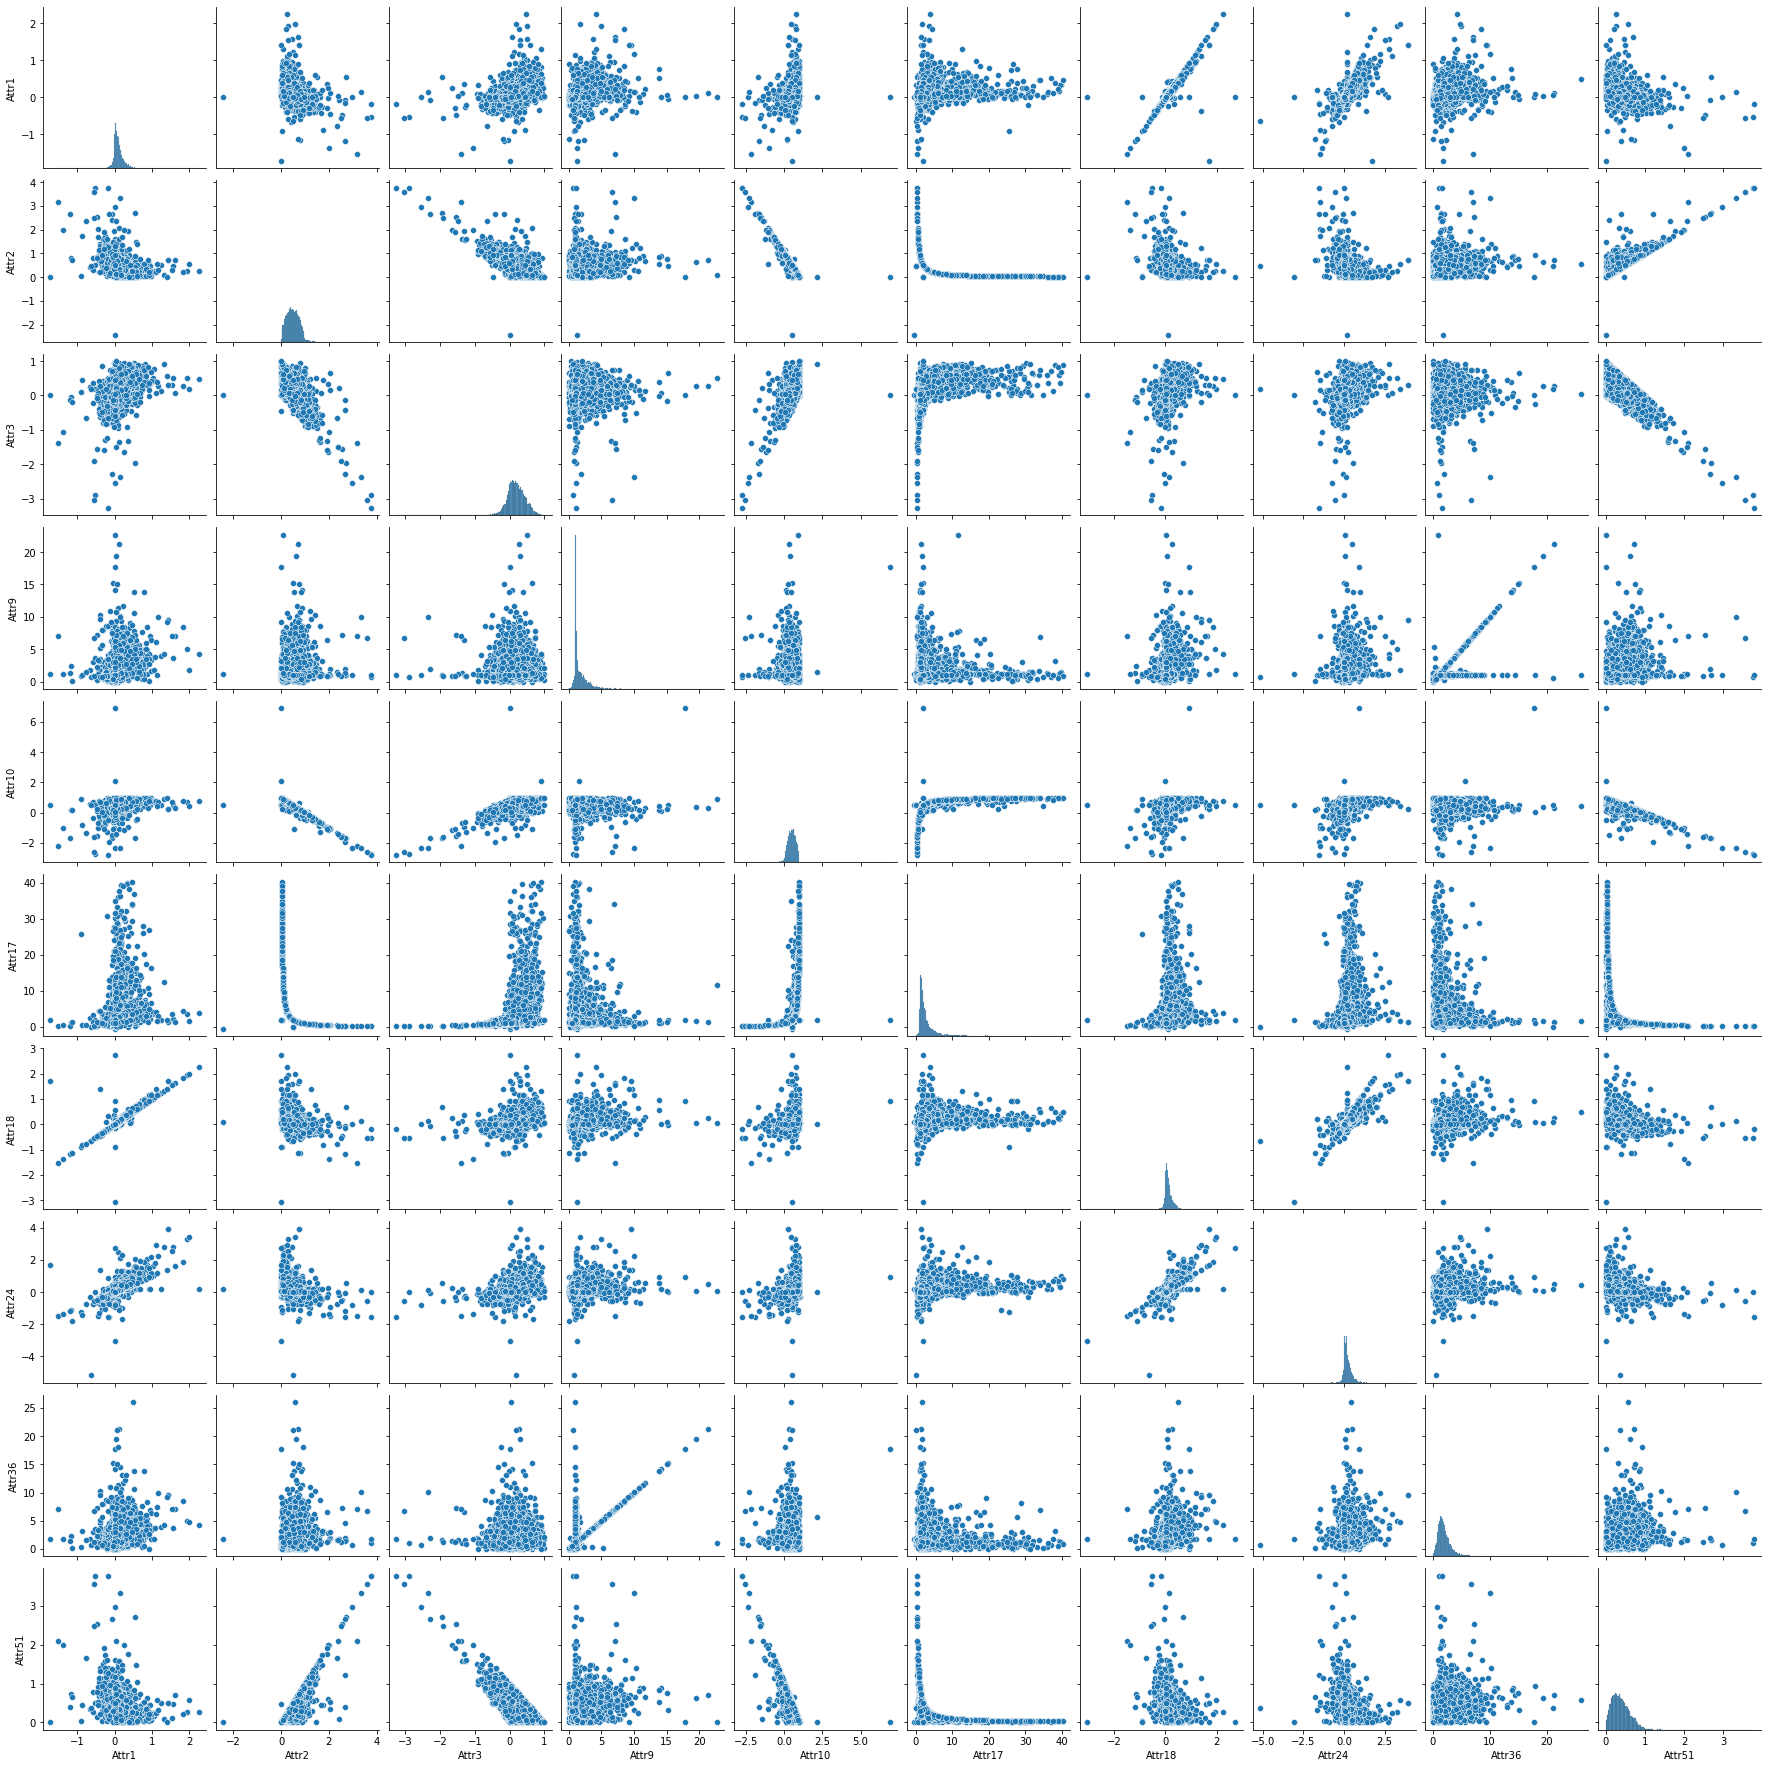

In [15]:
# EDA for dataset cleaned with missing values and outliers
# I would like to choose variables including calculation with total assets 
# which are Attr1, 2, 3, 9, 10, 17, 18, 24, 36, 51
# Pairplot amonng variables

sns.pairplot(data = df_cleaned, vars=['Attr1','Attr2','Attr3','Attr9','Attr10','Attr17','Attr18','Attr24','Attr36','Attr51'])
plt.show()


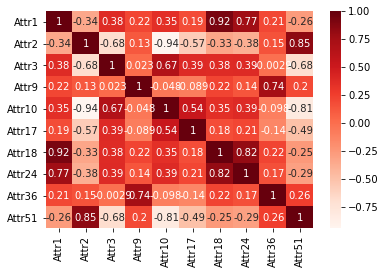

In [16]:
'''Interestingly, I could find some positive linear relation ship between 1(net profit / total assets) & 18(gross profit / total assets),
9(sales / total assets) & 36 (total sales / total assets), and negative linear relationship between 2(total liabilities / total assets)
& 10 (equity / total assets)'''
#Now applying correlation matrix among these vsriables

df_cleaned[['Attr1','Attr2','Attr3','Attr9','Attr10','Attr17','Attr18','Attr24','Attr36','Attr51']].corr()

#plot the correlation matrix of salary, balance and age in data dataframe.
sns.heatmap(df_cleaned[['Attr1','Attr2','Attr3','Attr9','Attr10','Attr17','Attr18','Attr24','Attr36','Attr51']].corr(), annot=True, cmap = 'Reds')
plt.show()

In [17]:
'''From the heatmap, there is a strong correlation between 1&18, 
1(net profit / total assets)&24(gross profit (in 3 years) / total assets), 
2(total liabilities / total assets)&51(X51 short-term liabilities / total assets), 
3(working capital / total assets)&10(equity / total assets), 
9(sales / total assets)&36(total sales / total assets), '''

'From the heatmap, there is a strong correlation between 1&18, \n1(net profit / total assets)&24(gross profit (in 3 years) / total assets), \n2(total liabilities / total assets)&51(X51 short-term liabilities / total assets), \n3(working capital / total assets)&10(equity / total assets), \n9(sales / total assets)&36(total sales / total assets), '

In [18]:
df_cleaned.iloc[:,0:64]

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,0.200550,0.37951,0.39641,2.04720,32.3510,0.388250,0.249760,1.330500,1.13890,0.504940,...,1604.8,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770
1,0.209120,0.49988,0.47225,1.94470,14.7860,0.000000,0.258340,0.996010,1.69960,0.497880,...,2304.6,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700
2,0.248660,0.69592,0.26713,1.55480,-1.1523,0.000000,0.309060,0.436950,1.30900,0.304080,...,6332.7,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780
3,0.081483,0.30734,0.45879,2.49280,51.9520,0.149880,0.092704,1.866100,1.05710,0.573530,...,20545.0,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970
4,0.187320,0.61323,0.22960,1.40630,-7.3128,0.187320,0.187320,0.630700,1.15590,0.386770,...,3186.6,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,0.018371,0.47410,-0.13619,0.60839,-18.4490,0.018371,0.018371,0.972030,1.01210,0.460840,...,-2732.8,0.011909,0.039866,0.98809,0.274140,73.5050,79.2370,31.268,11.6730,5.14890
7023,-0.013359,0.58354,-0.02265,0.92896,-42.2320,-0.013359,-0.015036,0.562890,0.98904,0.328470,...,-2557.1,-0.011082,-0.040671,1.01110,0.805920,10.5990,7.1740,94.092,3.8792,1.75720
7024,0.006338,0.50276,0.43923,1.87360,9.7417,0.006338,0.012022,0.983560,1.00830,0.494490,...,4826.9,0.008258,0.012817,0.99174,0.000000,10.4700,6.0759,51.019,7.1542,62.00100
7025,-0.041643,0.84810,-0.12852,0.57485,-121.9200,0.000000,-0.036795,0.179010,0.42138,0.151820,...,-1633.0,-0.232720,-0.274290,0.98788,3.593100,39.7030,3.1420,261.850,1.3939,0.51005


### 5) Applying PCA for dataframe A1

[ 27.88  38.09  46.51  51.85  56.69  60.48  63.53  66.14  68.38  70.52
  72.49  74.34  76.    77.6   79.04  80.46  81.76  83.01  84.22  85.35
  86.46  87.53  88.51  89.43  90.29  91.13  91.92  92.66  93.34  94.
  94.56  95.11  95.61  96.1   96.52  96.84  97.15  97.43  97.69  97.94
  98.17  98.38  98.57  98.74  98.9   99.04  99.17  99.29  99.4   99.49
  99.56  99.62  99.68  99.74  99.79  99.84  99.88  99.91  99.94  99.97
 100.   100.02 100.02 100.02]


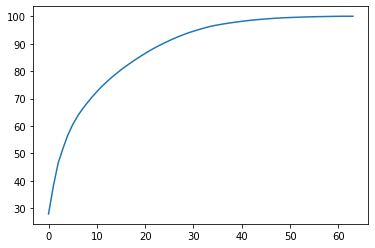

In [19]:
#Looking for number of componenets for PCA first

PCAx = df_cleaned.iloc[:,0:64].values
PCAx = scale(PCAx)
pca = PCA(n_components=64)
pca.fit(PCAx)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)

In [20]:
# select 19 componenets
pca = PCA(n_components=19)
pca_dt = pca.fit_transform(PCAx)

#Assign to A1
A1 = pd.DataFrame(data = pca_dt
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10', 'principal component 11', 'principal component 12', 'principal component 13', 'principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19'])
A1 = A1.join(df_cleaned["class"])

### 6) Apply Feature selection

#### 6-1) Use Chi2

In [21]:
X = df_cleaned.iloc[:,0:64]  #Attributes
y = df_cleaned.iloc[:,-1]    #Class

In [22]:
# Select K best with top 19 features
# there are negative values in the data so transform data to 0 to 1 so Chi2 can be applied
X_norm = (X-np.min(X))/(np.max(X) - np.min(X))
bestfeatures = SelectKBest(score_func=chi2, k=19)
fit = bestfeatures.fit(X_norm,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [23]:
chi_dt = pd.concat([dfcolumns, dfscores],axis = 1)
chi_dt.columns = ['variable','chi2']
chi_dt.sort_values('chi2', ascending = False).head(5)

,variable,chi2
50,Attr51,4.062888
61,Attr62,3.063732
3,Attr4,2.486879
49,Attr50,2.038689
16,Attr17,1.699714


#### 6-2) Use random forest

<AxesSubplot:>

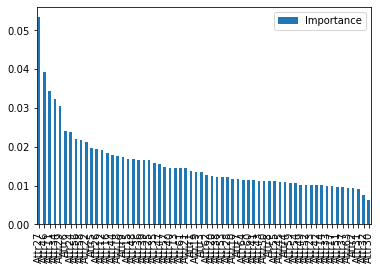

In [24]:
clf = RandomForestClassifier( n_estimators=19)
model = clf.fit(X,y)
feat_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

In [25]:
# just select top 20 variables
A2 = df_cleaned[feat_importances.index[0:19].tolist()+['class']]

#### 6-3) Wrapper methods with Recursive Feature Elimination

In [26]:
# utlizing Linear regression for the model
lin_reg = LinearRegression()

# create the RFE model with 19 attributes
rfe = RFE(lin_reg, n_features_to_select=19)
rfe.fit(X, y)

# summarize the selection of the attributes
print ("Number of selected features:",rfe.n_features_,"Selected Features:",\
           [feature for feature, rank in zip(X.columns.values, rfe.ranking_) if rank==1])

Number of selected features: 19 Selected Features: ['Attr1', 'Attr2', 'Attr7', 'Attr10', 'Attr11', 'Attr13', 'Attr14', 'Attr18', 'Attr19', 'Attr22', 'Attr23', 'Attr31', 'Attr35', 'Attr38', 'Attr39', 'Attr42', 'Attr51', 'Attr56', 'Attr58']


In [27]:
# select top columns
rfe_cols = [feature for feature, rank in zip(X.columns.values, rfe.ranking_) if rank==1]
A3 = df_cleaned[rfe_cols+['class']]


#### 6-4) Using Select K best with ANOVA f-test

In [28]:
select = SelectKBest(score_func=f_classif, k=19)
new = select.fit_transform(X,y)

#printing the features that have been selected using get_support()
cols = select.get_support(indices=True)

# select the main columns
A4 = df_cleaned.iloc[:,cols]
A4 = A4.join(df_cleaned["class"])

### 7) A5 for balancing the imbalanced class variable, choosing A3 datasets to balance the target variable

In [29]:
A3['class'].value_counts()

0    6756
1     271
Name: class, dtype: int64

In [30]:
#conda install -c conda-forge imbalanced-learn

In [31]:
X5 = A3.iloc[:,0:19]  #Attributes
y5 = A3.iloc[:,-1]    #Class

# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(X5, y5)
# assigning to A5
A5 = X_ros.join(y_ros)

A5 = X_ros.join(y_ros)

In [32]:
# new class distribution 
A5['class'].value_counts()

1    6756
0    6756
Name: class, dtype: int64

### 8) Applying classification models(Logistic regression, KNN, Random Forest, Gradient Boosting) to the datasets A1 to A5

#### 8-1)Logistic regression and evaluation

##### 8-1-1)Logistic regression with dataset A1

In [118]:
# Developing function for logistic regression

def model_fun_logistic(X_dt, y_dt):

    # traina and test split
    X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.33, random_state=1)

    # train model 
    md_obj = LogisticRegression(max_iter=2500)
    parameters = {
        'penalty':['L1']
    }
    cv = KFold(n_splits=5, random_state=1, shuffle=True)               
    grid_md = GridSearchCV(md_obj, parameters, cv= cv)
    grid_search = grid_md.fit(X_train ,y_train)
   
    # apply on the test
    test_preds = grid_md.predict(X_test)
    
    # confusion Matrix
    CM_lr = confusion_matrix(y_test, test_preds)

    # evaluate ROC and recall
    recall_lr = metrics.recall_score(y_test ,test_preds, pos_label='1')
    roc_lr = metrics.roc_auc_score(y_test ,test_preds)
                   
    return(recall_lr,roc_lr,CM_lr,grid_search.best_params_)


In [35]:
# A1 with Logistic regression
A1X = A1.iloc[:,:-1]  #Attributes
A1y = A1.iloc[:,-1]    #Class

model_fun_logistic(A1X, A1y)

(0.0,
 0.49977416440831074,
 array([[2213,    1],
        [ 105,    0]], dtype=int64))

In [117]:
model_fun_logistic(A1X, A1y)

C:\Users\elee0\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\elee0\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\elee0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\elee0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got L1.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\elee0\anaconda3\lib\site-packages\skle

(0.0,
 0.49977416440831074,
 array([[2213,    1],
        [ 105,    0]], dtype=int64),
 {'penalty': 'l2'})

##### 8-1-2)Logistic regression with dataset A2

In [36]:
# A2 with Logistic regression
A2X = A2.iloc[:,:-1]  #Attributes
A2y = A2.iloc[:,-1]    #Class

#Apply function with A2
model_fun_logistic(A2X, A2y)

(0.0,
 0.5,
 array([[2214,    0],
        [ 105,    0]], dtype=int64))

##### 8-1-3)Logistic regression with dataset A3

In [37]:
# A3 with Logistic regression
A3X = A3.iloc[:,:-1]  #Attributes
A3y = A3.iloc[:,-1]    #Class

#Apply function with A3
model_fun_logistic(A3X, A3y)

(0.009523809523809525,
 0.5043102335785262,
 array([[2212,    2],
        [ 104,    1]], dtype=int64))

##### 8-1-4)Logistic regression with dataset A4

In [38]:
# A4 with Logistic regression
A4X = A4.iloc[:,:-1]  #Attributes
A4y = A4.iloc[:,-1]    #Class

#Apply function with A4
model_fun_logistic(A4X, A4y)

(0.0,
 0.5,
 array([[2214,    0],
        [ 105,    0]], dtype=int64))

##### 8-1-5)Logistic regression with dataset A5

In [39]:
# A2 with Logistic regression
A5X = A5.iloc[:,:-1]  #Attributes
A5y = A5.iloc[:,-1]    #Class

#Apply function with A5
model_fun_logistic(A5X, A5y)

(0.7218453188602443,
 0.6996682110315456,
 array([[1523,  725],
        [ 615, 1596]], dtype=int64))

#### 8-2)KNN and evaluation with the test data set

##### 8-2-1)KNN with dataset A1

In [72]:
# Developing function for K Nearest Neighbor

def model_fun_KNN(X_dt, y_dt):

    # traina and test split
    X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.33, random_state=1)

    # requires normalization for better performance with KNN
    sc = StandardScaler()
    X_train_SC = sc.fit_transform(X_train)
    X_test_SC = sc.fit_transform(X_test)
    
    # train model
    md_obj = KNeighborsClassifier(n_neighbors = 5)
    
    # grid search for number of neighbors
    k_range = list(range(1, 10))
    param_grid = dict(n_neighbors=k_range)
    cv = KFold(n_splits=5, random_state=1, shuffle=True)               
    grid_md = GridSearchCV(md_obj, param_grid, cv= cv)
    grid_search = grid_md.fit(X_train_SC ,y_train)
        
    # apply on the test
    test_preds = grid_md.predict(X_test_SC)

    # confusion matrix
    CM_KNN = confusion_matrix(y_test, test_preds)
    
    # evaluate ROC and recall
    recall_lr = metrics.recall_score(y_test ,test_preds, pos_label='1')
    roc_lr = metrics.roc_auc_score(y_test ,test_preds)
                   
    return(recall_lr,roc_lr,CM_KNN, grid_search.best_params_)

In [73]:
model_fun_KNN(A1X, A1y)

(0.0,
 0.5,
 array([[2214,    0],
        [ 105,    0]], dtype=int64),
 {'n_neighbors': 8})

##### 8-2-2)KNN with dataset A2

In [74]:
model_fun_KNN(A2X, A2y)

(0.0,
 0.5,
 array([[2214,    0],
        [ 105,    0]], dtype=int64),
 {'n_neighbors': 8})

##### 8-2-3)KNN with dataset A3

In [75]:
model_fun_KNN(A3X, A3y)

(0.0,
 0.5,
 array([[2214,    0],
        [ 105,    0]], dtype=int64),
 {'n_neighbors': 4})

##### 8-2-4)KNN with dataset A4

In [76]:
model_fun_KNN(A4X, A4y)

(0.0,
 0.5,
 array([[2214,    0],
        [ 105,    0]], dtype=int64),
 {'n_neighbors': 7})

##### 8-2-5)KNN with dataset A5

In [77]:
model_fun_KNN(A5X, A5y)

(0.9764812302125735,
 0.9675555617255039,
 array([[2155,   93],
        [  52, 2159]], dtype=int64),
 {'n_neighbors': 1})

#### 8-3)Random Forest and evaluation with the test data set

##### 8-3-1)RF with dataset A1

In [98]:
# Developing function for random forest

def model_fun_RF(X_dt, y_dt):

    # traina and test split
    X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.33, random_state=1)

    # train model
    md_obj = RandomForestClassifier(n_estimators=100)
    parameters = {
        'n_estimators': [100, 200, 500],
            }
    cv = KFold(n_splits=5, random_state=1, shuffle=True)               
    grid_md = GridSearchCV(md_obj, parameters, cv= cv)
    grid_search = grid_md.fit(X_train ,y_train)
   
    # apply on the test
    test_preds = grid_md.predict(X_test)
    
    #Confusion Matrix
    CM_lr = confusion_matrix(y_test, test_preds)

    # evaluate ROC and recall
    recall_lr = metrics.recall_score(y_test ,test_preds,pos_label='1')
    roc_lr = metrics.roc_auc_score(y_test ,test_preds)
                   
    return(recall_lr,roc_lr,CM_lr,grid_search.best_params_)

In [99]:
model_fun_RF(A1X, A1y)

(0.0,
 0.499096657633243,
 array([[2210,    4],
        [ 105,    0]], dtype=int64),
 {'n_estimators': 200})

##### 8-3-2)RF with dataset A2

In [100]:
model_fun_RF(A2X, A2y)

(0.37142857142857144,
 0.685036778939218,
 array([[2211,    3],
        [  66,   39]], dtype=int64),
 {'n_estimators': 500})

##### 8-3-3)RF with dataset A3

In [101]:
model_fun_RF(A3X, A3y)

(0.06666666666666667,
 0.5317524841915086,
 array([[2207,    7],
        [  98,    7]], dtype=int64),
 {'n_estimators': 200})

##### 8-3-4)RF with dataset A4

In [102]:
model_fun_RF(A4X, A4y)

(0.01904761904761905,
 0.5077171247902955,
 array([[2206,    8],
        [ 103,    2]], dtype=int64),
 {'n_estimators': 200})

##### 8-3-5)RF with dataset A5

In [103]:
model_fun_RF(A5X, A5y)

(1.0,
 0.9946619217081851,
 array([[2224,   24],
        [   0, 2211]], dtype=int64),
 {'n_estimators': 500})

#### 8-4)Gradient Boosting Model and evaluation with the test data set

##### 8-4-1)GBM with dataset A1

In [106]:
# Developing function for gradient boosting model

def model_fun_GB(X_dt, y_dt):

    # traina and test split
    X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.33, random_state=1)

    # train model
    md_obj = GradientBoostingClassifier()
    parameters = {
        "learning_rate": [0.01, 0.05, 0.1, 0.2]
            }
    cv = KFold(n_splits=5, random_state=1, shuffle=True)               
    grid_md = GridSearchCV(md_obj, parameters, cv= cv)
    grid_search = grid_md.fit(X_train ,y_train)
   
    # apply on the test
    test_preds = grid_md.predict(X_test)
    
    #Confusion Matrix
    CM_lr = confusion_matrix(y_test, test_preds)

    # evaluate ROC and recall
    recall_lr = metrics.recall_score(y_test ,test_preds,pos_label='1')
    roc_lr = metrics.roc_auc_score(y_test ,test_preds)
                   
    return(recall_lr,roc_lr,CM_lr,grid_search.best_params_)

In [107]:
model_fun_GB(A1X, A1y)

(0.01904761904761905,
 0.5086204671570526,
 array([[2210,    4],
        [ 103,    2]], dtype=int64),
 {'learning_rate': 0.05})

##### 8-4-2)GBM with dataset A2

In [108]:
model_fun_GB(A2X, A2y)

(0.38095238095238093,
 0.6893470125177442,
 array([[2209,    5],
        [  65,   40]], dtype=int64),
 {'learning_rate': 0.1})

##### 8-4-3)GBM with dataset A3

In [109]:
model_fun_GB(A3X, A3y)

(0.10476190476190476,
 0.5521551167892631,
 array([[2213,    1],
        [  94,   11]], dtype=int64),
 {'learning_rate': 0.05})

##### 8-4-4)GBM with dataset A4

In [110]:
model_fun_GB(A4X, A4y)

(0.009523809523809525,
 0.5047619047619047,
 array([[2214,    0],
        [ 104,    1]], dtype=int64),
 {'learning_rate': 0.01})

##### 8-4-5)GBM with dataset A5

In [111]:
model_fun_GB(A5X, A5y)

(0.984622342831298,
 0.9375958689245458,
 array([[2002,  246],
        [  34, 2177]], dtype=int64),
 {'learning_rate': 0.2})

### Conclusion

In [ ]:
'''
All the imbalanced dataset (A1~A4) did not perform well with the modeling.
Dataset A5 which oversampled A3 has the best scores for Recall and AUC_ROC score.
Random Forest has the highgest score following by the K nearest neighbor, and gradient boosting model. Logistic regression wasn't effective compred to the other models.
'''